In [35]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from seirsplus.models import *
import networkx
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind

In [49]:
def plot_models(model, cmodel, cpmodel=None, cpcontrol=None, title="", tmax=500):
    if cpmodel is None:
        cpmodel = []
    cpmodel.append((tmax, ""))
    if cpcontrol is None:
        cpcontrol = []
    cpcontrol.append((tmax, ""))

    y_max = np.max((np.max(cmodel.numI), np.max(cmodel.numE), np.max(cmodel.numD_E), np.max(cmodel.numD_I), np.max(model.numI), np.max(model.numE), np.max(model.numD_E), np.max(model.numD_I)))
    fig = plt.figure(figsize=(13,6))
    fig.suptitle(title)
    ax=plt.subplot(221)
    plt.plot(model.tseries, model.numS, label="Susceptible")
    plt.plot(model.tseries, model.numI, label="Infectious")
    plt.plot(model.tseries, model.numE, label="Exposed")
    plt.plot(model.tseries, model.numR, label="Recovered")
    plt.plot(model.tseries, model.numD_E, label="Detected (exposed)")
    plt.plot(model.tseries, model.numD_I, label="Detected (infectious)")
    checkpoints = cpmodel
    for i in range(len(checkpoints) - 1):
        ax.axvspan(checkpoints[i][0], checkpoints[i+1][0], alpha=0.15, color=plt.cm.tab10(i))
        plt.text(np.mean((checkpoints[i][0], checkpoints[i+1][0])), 5000, checkpoints[i][1], fontsize=12, rotation=90, va="center", ha="center", color="grey", zorder=-1)
    plt.ylabel("Number of individuals")
    plt.title(f"Testing from day {test_start} ({int(model.numF[-1])} dead, i.e. {model.numF[-1] / model.numNodes * 100:.2f}%)")
    plt.xticks([])
    
    ax=plt.subplot(223)
    plt.plot(model.tseries, model.numS, label="Susceptible")
    plt.plot(model.tseries, model.numI, label="Infectious")
    plt.plot(model.tseries, model.numE, label="Exposed")
    plt.plot(model.tseries, model.numR, label="Recovered")
    plt.plot(model.tseries, model.numD_E, label="Detected (exposed)")
    plt.plot(model.tseries, model.numD_I, label="Detected (infectious)")
    checkpoints = cpmodel
    for i in range(len(checkpoints) - 1):
        ax.axvspan(checkpoints[i][0], checkpoints[i+1][0], alpha=0.15, color=plt.cm.tab10(i))
    plt.ylabel("Number of individuals\n(zoomed in)")
    plt.xlabel("Days")
    plt.ylim(0, y_max)

    ax=plt.subplot(222)
    plt.plot(cmodel.tseries, cmodel.numS, label="Susceptible")
    plt.plot(cmodel.tseries, cmodel.numI, label="Infectious")
    plt.plot(cmodel.tseries, cmodel.numE, label="Exposed")
    plt.plot(cmodel.tseries, cmodel.numR, label="Recovered")
    plt.plot(cmodel.tseries, cmodel.numD_E, label="Detected (exposed)")
    plt.plot(cmodel.tseries, cmodel.numD_I, label="Detected (infectious)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    checkpoints = cpcontrol
    for i in range(len(checkpoints) - 1):
        ax.axvspan(checkpoints[i][0], checkpoints[i+1][0], alpha=0.15, color=plt.cm.tab10(i))
        plt.text(np.mean((checkpoints[i][0], checkpoints[i+1][0])), 5000, checkpoints[i][1], fontsize=12, rotation=90, va="center", ha="center", color="grey", zorder=-1)
    plt.ylabel("Number of individuals")
    plt.title(f"No testing ({int(cmodel.numF[-1])} dead, i.e. {cmodel.numF[-1] / cmodel.numNodes * 100:.2f}%)")
    plt.xticks([])
    
    ax=plt.subplot(224)
    plt.plot(cmodel.tseries, cmodel.numS, label="Susceptible")
    plt.plot(cmodel.tseries, cmodel.numI, label="Infectious")
    plt.plot(cmodel.tseries, cmodel.numE, label="Exposed")
    plt.plot(cmodel.tseries, cmodel.numR, label="Recovered")
    plt.plot(cmodel.tseries, cmodel.numD_E, label="Detected (exposed)")
    plt.plot(cmodel.tseries, cmodel.numD_I, label="Detected (infectious)")
    checkpoints = cpmodel
    for i in range(len(checkpoints) - 1):
        ax.axvspan(checkpoints[i][0], checkpoints[i+1][0], alpha=0.15, color=plt.cm.tab10(i))
    plt.ylabel("Number of individuals\n(zoomed in)")
    plt.xlabel("Days")
    plt.ylim(0, y_max)

 87%|████████▋ | 437/500 [01:05<00:09,  6.69it/s, S=1783.0, E=0, I=0, R=8151.0, D=0, cE=8117.0]       


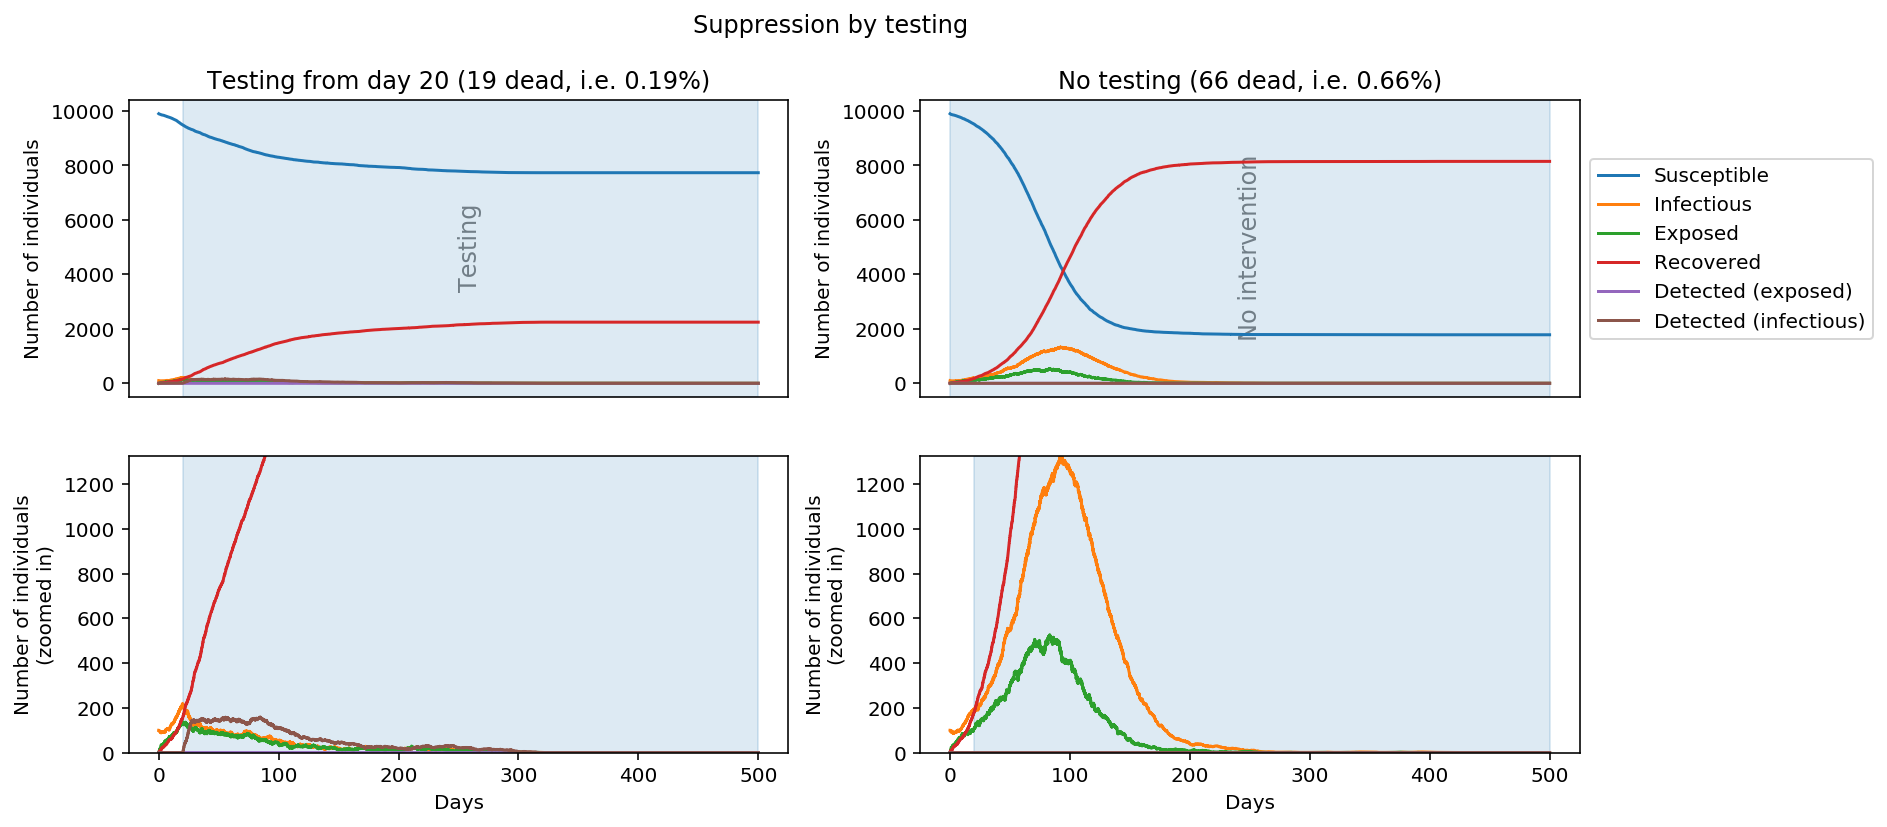

In [54]:
numNodes = 10000           # Size of the population
n_days = 500               # Number of days to simulate
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
G_normal     = custom_exponential_graph(baseGraph, scale=100)
G_quarantine = custom_exponential_graph(baseGraph, scale=5)


model_params = dict(
    G=G_normal,             # Social graph under normal conditions
    beta=0.17,              # Rate of transmission (transmissions per S-I contact per day)
    sigma=1/5,              # Rate of progression (inverse of incubation period)
    gamma=1/14,             # Rate of recovery (inverse of infectious period)
    mu_I=0.0005,             # Death rate of infected individuals
    p=0.25,                 # Locality of contacts (p=0, only local; p=1, only global)
    Q=G_quarantine,         # Social graph under quarantine (applies only to quarantined individuals)
    beta_D=0.17,            # Rate of transmission for detected cases
    sigma_D=1/5,            # Rate of progression for detected cases
    gamma_D=1/14,           # Rate of recovery for detected cases
    mu_D=0.0005,             # Death rate of detected individuals 
    theta_E=0,              # Rate of testing for exposed individuals
    theta_I=0,              # Rate of testing for infectious individuals
    phi_E=0,                # Rate of contact tracing testing for exposed individuals
    phi_I=0,                # Rate of contact tracing testing for infectious individuals
    psi_E=0.8,             # probability that an exposed individual is correctly identified when tested
    psi_I=0.8,             # probability that an infected individual is correctly identified when tested
    q=0.02,                 # Probability of global interactions for quarantined individuals
    initI=100               # Initial number of infected individuals
)

test_start = 20 # On what day do we start testing?
test_fraction = 1/7 # probability that a person is tested any given day

model = SEIRSNetworkModel(**model_params)
checkpoints = {'t': [test_start], 'theta_E': [test_fraction], 'theta_I': [test_fraction]}
model.run(T=n_days, checkpoints=checkpoints, verbose=False)

# Control model, identical to the above, except we don't use the testing checkpoint
cmodel = SEIRSNetworkModel(**model_params)
cmodel.run(T=n_days, verbose=False)
plot_models(model, cmodel, [(test_start, "Testing")], [(0, "No intervention")], "Suppression by testing")

In [4]:
numNodes = 10000           # Size of the population
n_days = 500               # Number of days to simulate
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
G_normal     = custom_exponential_graph(baseGraph, scale=100)
G_quarantine = custom_exponential_graph(baseGraph, scale=5)


models = []
for test_fraction in [1, 1/2, 1/5, 1/7, 1/14, 1/21, 1/100, 0]:
    for _ in range(10):
        model_params = dict(
            G=G_normal,             # Social graph under normal conditions
            beta=0.17,              # Rate of transmission (transmissions per S-I contact per day)
            sigma=1/5,              # Rate of progression (inverse of incubation period)
            gamma=1/14,             # Rate of recovery (inverse of infectious period)
            mu_I=0.0005,            # Death rate of infected individuals
            p=0.25,                 # Locality of contacts (p=0, only local; p=1, only global)
            Q=G_quarantine,         # Social graph under quarantine (applies only to quarantined individuals)
            beta_D=0.17,            # Rate of transmission for detected cases
            sigma_D=1/5,            # Rate of progression for detected cases
            gamma_D=1/14,           # Rate of recovery for detected cases
            mu_D=0.0005,            # Death rate of detected individuals 
            theta_E=0,              # Rate of testing for exposed individuals
            theta_I=0,              # Rate of testing for infectious individuals
            phi_E=0,                # Rate of contact tracing testing for exposed individuals
            phi_I=0,                # Rate of contact tracing testing for infectious individuals
            psi_E=0.67,             # probability that an exposed individual is correctly identified when tested
            psi_I=0.67,             # probability that an infected individual is correctly identified when tested
            q=0.02,                 # Probability of global interactions for quarantined individuals
            initI=100               # Initial number of infected individuals
        )

        test_start = 20 # On what day do we start testing?
        # test_fraction = 1/14 # probability that a person is tested any given day

        model = SEIRSNetworkModel(**model_params)
        checkpoints = {'t': [test_start], 'theta_E': [test_fraction], 'theta_I': [test_fraction]}
        model.run(T=n_days, checkpoints=checkpoints, verbose=False)
        models.append(model)

 67%|██████▋   | 337/500 [00:52<00:25,  6.45it/s, S=4209.0, E=0, I=0, R=5746.0, D=0, cE=5691.0]      
506it [00:51,  9.84it/s, S=4303.0, E=0, I=0, R=5651.0, D=0, cE=5597.0]                               
 53%|█████▎    | 265/500 [01:14<01:05,  3.57it/s, S=1700.0, E=0, I=0, R=8254.0, D=0, cE=8200.0]       


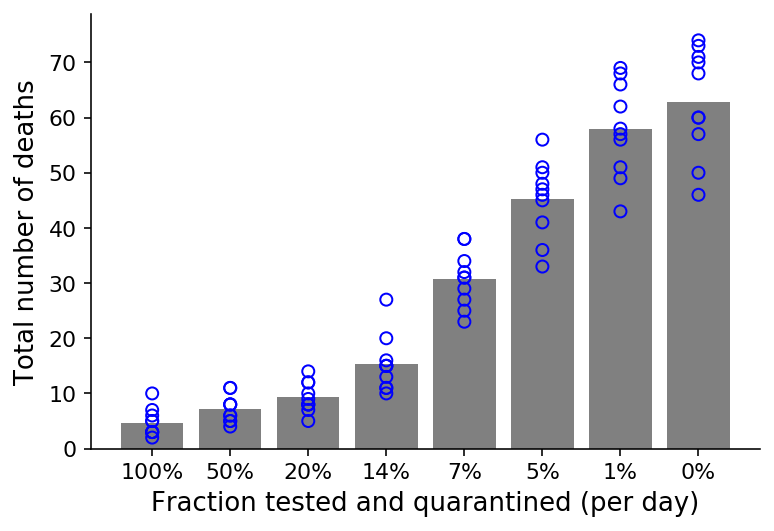

In [67]:
models = models1
ax=plt.subplot()
plt.bar(np.arange(8), np.reshape([m.numF[-1] for m in models], (8,10)).mean(axis=1), zorder=-1, color="grey")
for ix in range(10):
    plt.scatter(np.arange(8), [m.numF[-1] for m in models[ix::10]], marker="o", lw=1, ec="blue", color="none")
plt.xticks(np.arange(8), labels=["100%", "50%", "20%", "14%", "7%", "5%", "1%", "0%"], fontsize=11)
plt.yticks(np.arange(0,80,10), fontsize=11)
plt.xlabel("Fraction tested and quarantined (per day)", fontsize=13)
plt.ylabel("Total number of deaths", fontsize=13)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
None

In [6]:
models1 = models

In [7]:
numNodes = 10000           # Size of the population
n_days = 500               # Number of days to simulate
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
G_normal     = custom_exponential_graph(baseGraph, scale=100)
G_quarantine = custom_exponential_graph(baseGraph, scale=5)


models = []
for test_fraction in [1, 1/2, 1/5, 1/7, 1/14, 1/21, 1/100, 0]:
    for _ in range(10):
        model_params = dict(
            G=G_normal,             # Social graph under normal conditions
            beta=0.17,              # Rate of transmission (transmissions per S-I contact per day)
            sigma=1/5,              # Rate of progression (inverse of incubation period)
            gamma=1/14,             # Rate of recovery (inverse of infectious period)
            mu_I=0.0005,            # Death rate of infected individuals
            p=0.25,                 # Locality of contacts (p=0, only local; p=1, only global)
            Q=G_quarantine,         # Social graph under quarantine (applies only to quarantined individuals)
            beta_D=0.17,            # Rate of transmission for detected cases
            sigma_D=1/5,            # Rate of progression for detected cases
            gamma_D=1/14,           # Rate of recovery for detected cases
            mu_D=0.0005,            # Death rate of detected individuals 
            theta_E=0,              # Rate of testing for exposed individuals
            theta_I=0,              # Rate of testing for infectious individuals
            phi_E=0,                # Rate of contact tracing testing for exposed individuals
            phi_I=0,                # Rate of contact tracing testing for infectious individuals
            psi_E=0.67,             # probability that an exposed individual is correctly identified when tested
            psi_I=0.67,             # probability that an infected individual is correctly identified when tested
            q=0.02,                 # Probability of global interactions for quarantined individuals
            initI=100               # Initial number of infected individuals
        )

        test_start = 20 # On what day do we start testing?
        # test_fraction = 1/14 # probability that a person is tested any given day

        model = SEIRSNetworkModel(**model_params)
        sweep = np.zeros((n_days - test_start, numNodes))
        n_tested = int(numNodes * test_fraction)
        for i in range(n_days - test_start):
            sweep[i, (i * n_tested) % numNodes:(i * n_tested) % numNodes + n_tested] = 1
            if sweep[i, :].sum() != n_tested:
                sweep[i, 0:((i + 1)* n_tested) % numNodes] = 1

        checkpoints = {'t': np.arange(test_start, n_days), 'theta_E': sweep, 'theta_I': sweep}
        model.run(T=n_days, checkpoints=checkpoints, verbose=False)
        models.append(model)

 85%|████████▍ | 424/500 [00:49<00:08,  8.51it/s, S=5782.0, E=0, I=0, R=4185.0, D=0, cE=4118.0]      
505it [01:02,  8.09it/s, S=4955.0, E=1, I=2, R=5009.0, D=0, cE=4945.0]                               
507it [00:57,  8.88it/s, S=5295.0, E=0, I=0, R=4668.0, D=0, cE=4605.0]                               
 52%|█████▏    | 262/500 [01:16<01:09,  3.44it/s, S=1630.0, E=0, I=0, R=8306.0, D=0, cE=8270.0]       


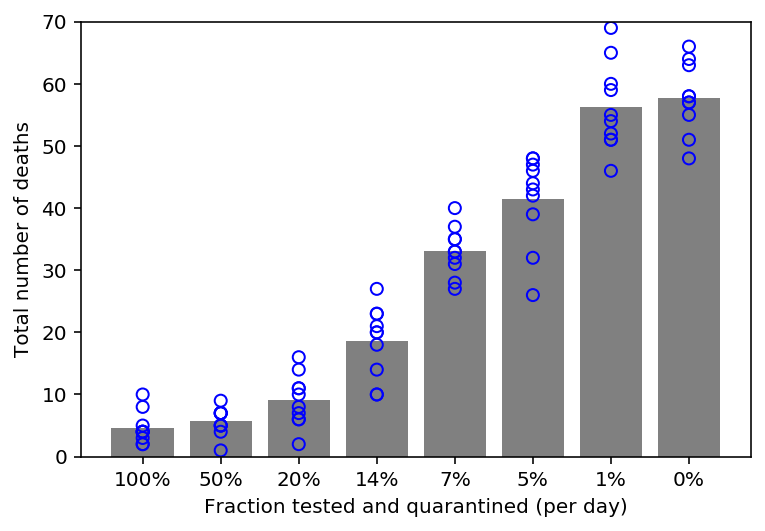

In [8]:
plt.bar(np.arange(8), np.reshape([m.numF[-1] for m in models], (8,10)).mean(axis=1), zorder=-1, color="grey")
for ix in range(10):
    plt.scatter(np.arange(8), [m.numF[-1] for m in models[ix::10]], marker="o", lw=1, ec="blue", color="none")
plt.xticks(np.arange(8), labels=["100%", "50%", "20%", "14%", "7%", "5%", "1%", "0%"])
plt.xlabel("Fraction tested and quarantined (per day)")
plt.ylabel("Total number of deaths")
plt.ylim(0,70)
None

In [9]:
models2 = models

In [10]:
numNodes = 10000           # Size of the population
n_days = 500               # Number of days to simulate
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
G_normal     = custom_exponential_graph(baseGraph, scale=100)
G_quarantine = custom_exponential_graph(baseGraph, scale=5)


models = []
for test_freq in [1, 2, 5, 7, 14, 21, 100, 0]:
    for _ in range(10):
        model_params = dict(
            G=G_normal,             # Social graph under normal conditions
            beta=0.17,              # Rate of transmission (transmissions per S-I contact per day)
            sigma=1/5,              # Rate of progression (inverse of incubation period)
            gamma=1/14,             # Rate of recovery (inverse of infectious period)
            mu_I=0.0005,            # Death rate of infected individuals
            p=0.25,                 # Locality of contacts (p=0, only local; p=1, only global)
            Q=G_quarantine,         # Social graph under quarantine (applies only to quarantined individuals)
            beta_D=0.17,            # Rate of transmission for detected cases
            sigma_D=1/5,            # Rate of progression for detected cases
            gamma_D=1/14,           # Rate of recovery for detected cases
            mu_D=0.0005,            # Death rate of detected individuals 
            theta_E=0,              # Rate of testing for exposed individuals
            theta_I=0,              # Rate of testing for infectious individuals
            phi_E=0,                # Rate of contact tracing testing for exposed individuals
            phi_I=0,                # Rate of contact tracing testing for infectious individuals
            psi_E=0.67,             # probability that an exposed individual is correctly identified when tested
            psi_I=0.67,             # probability that an infected individual is correctly identified when tested
            q=0.02,                 # Probability of global interactions for quarantined individuals
            initI=100               # Initial number of infected individuals
        )

        test_start = 20 # On what day do we start testing?
        # test_fraction = 1/14 # probability that a person is tested any given day

        model = SEIRSNetworkModel(**model_params)
        sweep = np.zeros((n_days - test_start, numNodes))
        if test_freq > 0:
            for i in range(0, n_days - test_start, test_freq):
                sweep[i, :] = 1

        checkpoints = {'t': np.arange(test_start, n_days), 'theta_E': sweep, 'theta_I': sweep}
        model.run(T=n_days, checkpoints=checkpoints, verbose=False)
        models.append(model)

 72%|███████▏  | 360/500 [01:05<00:25,  5.51it/s, S=1590.0, E=0, I=0, R=8356.0, D=0, cE=8310.0]       


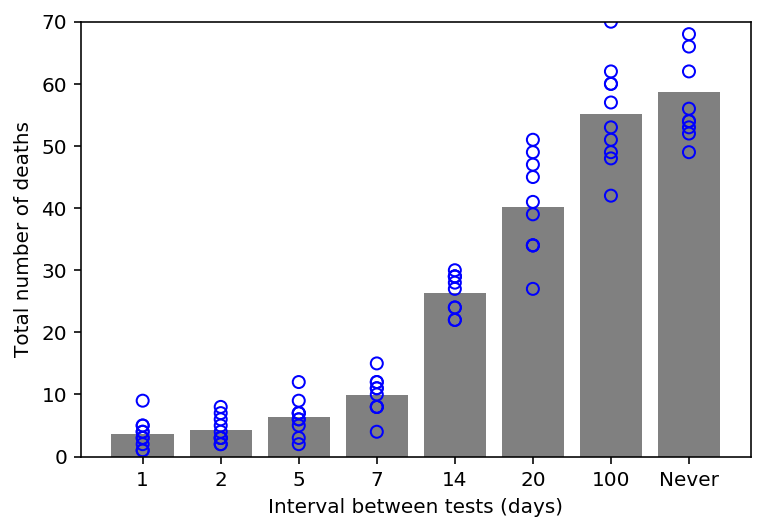

In [11]:
plt.bar(np.arange(8), np.reshape([m.numF[-1] for m in models], (8,10)).mean(axis=1), zorder=-1, color="grey")
for ix in range(10):
    plt.scatter(np.arange(8), [m.numF[-1] for m in models[ix::10]], marker="o", lw=1, ec="blue", color="none")
plt.xticks(np.arange(8), labels=["1", "2", "5", "7", "14", "20", "100", "Never"])
plt.xlabel("Interval between tests (days)")
plt.ylabel("Total number of deaths")
plt.ylim(0,70)
None

In [12]:
models3 = models

In [38]:
ma = models2
mb = models3
for ix in range(10):
    a = [m.numF[-1] for m in ma[ix::10]]
    b = [m.numF[-1] for m in mb[ix::10]]
    print(ttest_ind(a, b).pvalue)

0.8681549095169497
0.9111929997561607
0.8863428322857703
0.7580155001685005
0.6180853735269104
0.9921817443005814
0.8183811056785302
0.5289381481978056
0.701349515104217
0.8968385405807751


 77%|███████▋  | 386/500 [01:06<00:19,  5.85it/s, S=1680.0, E=0, I=0, R=8263.0, D=0, cE=8220.0]       


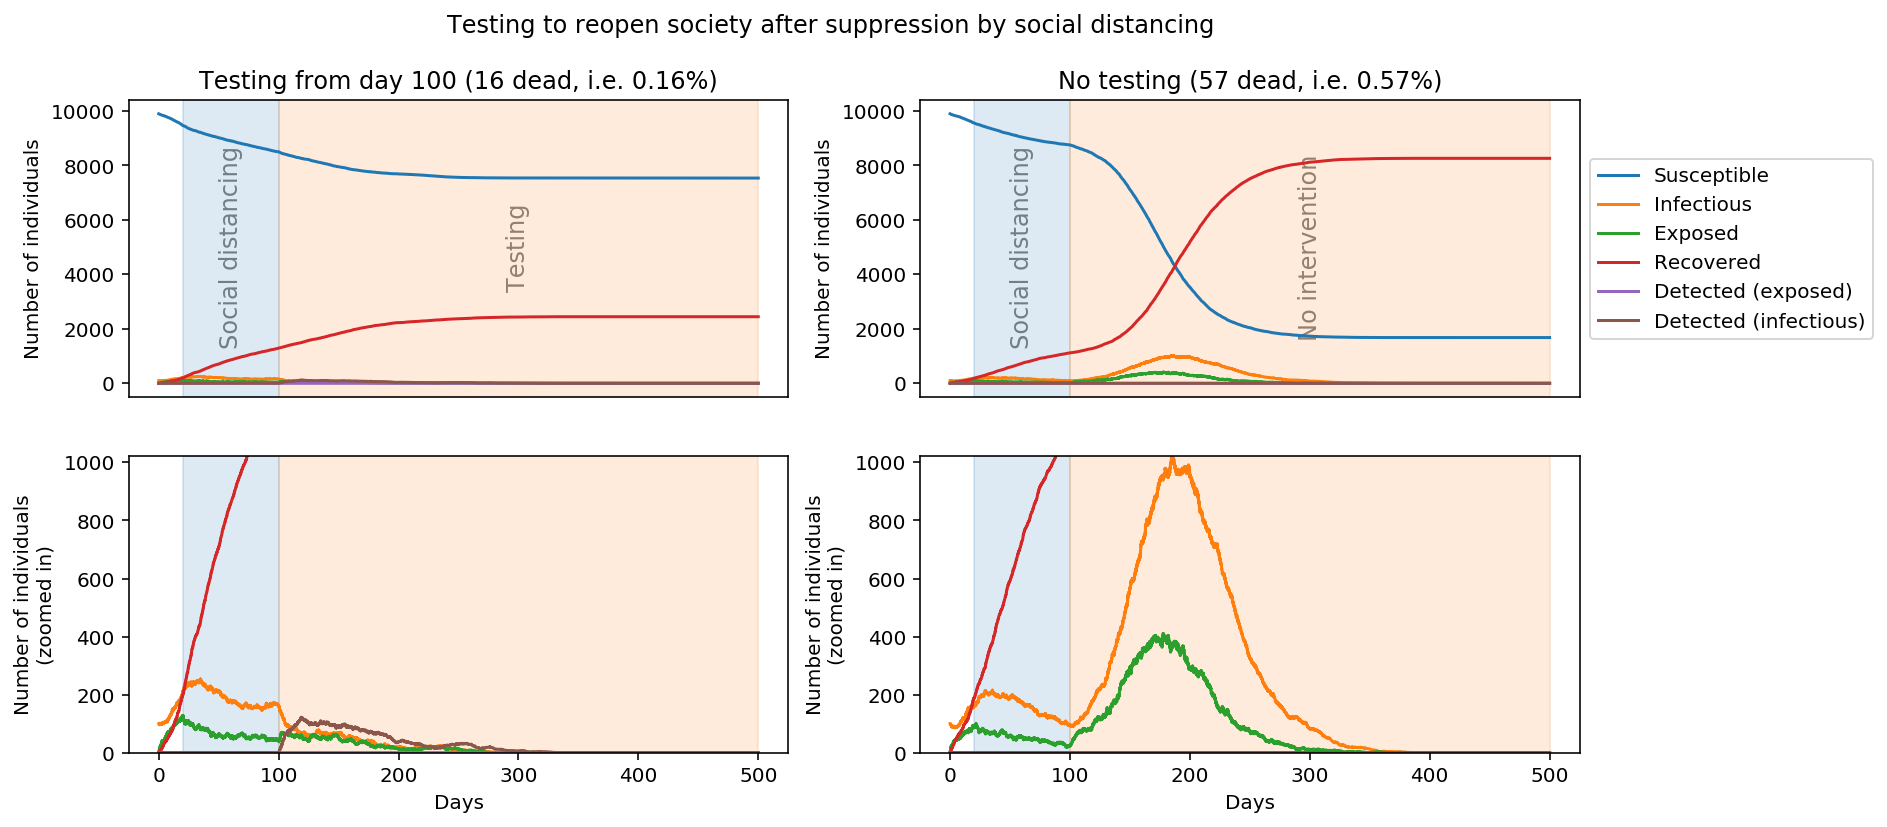

In [55]:
numNodes = 10000
n_days = 500
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
G_normal     = custom_exponential_graph(baseGraph, scale=100)
G_distancing = custom_exponential_graph(baseGraph, scale=5)
G_quarantine = custom_exponential_graph(baseGraph, scale=5)

model_params = dict(
    G=G_normal,             # Social graph under normal conditions
    beta=0.17,              # Rate of transmission (transmissions per S-I contact per day)
    sigma=1/5,              # Rate of progression (inverse of incubation period)
    gamma=1/14,             # Rate of recovery (inverse of infectious period)
    mu_I=0.0005,            # Death rate of infected individuals
    p=0.25,                 # Locality of contacts (p=0, only local; p=1, only global)
    Q=G_quarantine,         # Social graph under quarantine (applies only to quarantined individuals)
    beta_D=0.17,            # Rate of transmission for detected cases
    sigma_D=1/5,            # Rate of progression for detected cases
    gamma_D=1/14,           # Rate of recovery for detected cases
    mu_D=0.0005,            # Death rate of detected individuals 
    theta_E=0,              # Rate of testing for exposed individuals
    theta_I=0,              # Rate of testing for infectious individuals
    phi_E=0,                # Rate of contact tracing testing for exposed individuals
    phi_I=0,                # Rate of contact tracing testing for infectious individuals
    psi_E=0.8,             # probability that an exposed individual is correctly identified when tested
    psi_I=0.8,             # probability that an infected individual is correctly identified when tested
    q=0.02,                 # Probability of global interactions for quarantined individuals
    initI=100               # Initial number of infected individuals
)

dist_start = 20 # On what day do we start social distancing?
test_start = 100 # On what day do we start testing?
test_fraction = 1/7 # probability that a person is tested any given day

model = SEIRSNetworkModel(**model_params)
checkpoints = {'t': [dist_start, test_start], 'G': [G_distancing, G_normal], 'p': [0.02, 0.5], 'theta_E': [0, test_fraction], 'theta_I': [0, test_fraction]}
model.run(T=n_days, checkpoints=checkpoints, verbose=False)

# Control model, identical to the above, except we don't start testing at the testing checkpoint
cmodel = SEIRSNetworkModel(**model_params)
checkpoints = {'t': [dist_start, test_start], 'G': [G_distancing, G_normal], 'p': [0.02, 0.5], 'theta_E': [0, 0], 'theta_I': [0, 0]}
cmodel.run(T=n_days, checkpoints=checkpoints, verbose=False)
plot_models(model, cmodel, [(dist_start, "Social distancing"), (test_start, "Testing")], [(dist_start, "Social distancing"), (test_start, "No intervention")], "Testing to reopen society after suppression by social distancing")

In [152]:
def plot_degree_distn(graph, max_degree=None, show=True, use_seaborn=True):
    import matplotlib.pyplot as pyplot
    if(use_seaborn):
        import seaborn
        seaborn.set_style('ticks')
        seaborn.despine()
    # Get a list of the node degrees:
    if type(graph)==numpy.ndarray:
        nodeDegrees = graph.sum(axis=0).reshape((graph.shape[0],1))   # sums of adj matrix cols
    elif type(graph)==networkx.classes.graph.Graph:
        nodeDegrees = [d[1] for d in graph.degree()]
    else:
        raise BaseException("Input an adjacency matrix or networkx object only.")
    # Calculate the mean degree:
    meanDegree = numpy.mean(nodeDegrees)
    # Generate a histogram of the node degrees:
    pyplot.hist(nodeDegrees, bins=range(max(nodeDegrees)), alpha=0.5, color='tab:blue', label=('mean degree = %.1f' % meanDegree))
    pyplot.xlim(0, max(nodeDegrees) if not max_degree else max_degree)
    pyplot.xlabel('degree')
    pyplot.ylabel('num nodes')
    pyplot.legend(loc='upper right')
    if(show):
        pyplot.show()

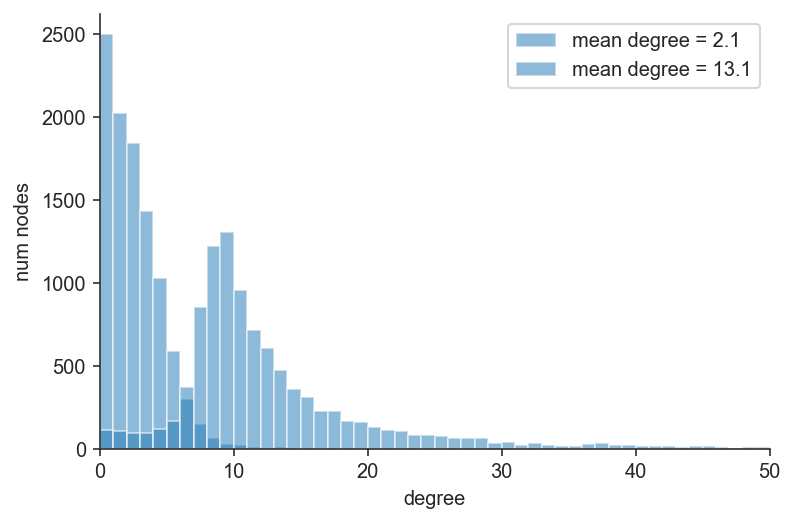

In [16]:
plot_degree_distn(G_quarantine, max_degree=50, show=False)
plot_degree_distn(G_normal, max_degree=50, show=True)

In [41]:
numNodes = 10000           # Size of the population
n_days = 500               # Number of days to simulate
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
G_normal     = custom_exponential_graph(baseGraph, scale=100)
G_distancing = custom_exponential_graph(baseGraph, scale=5)
G_quarantine = custom_exponential_graph(baseGraph, scale=5)


models = []
for test_fraction in [1/7, 1/9, 1/11, 1/13, 1/15, 0]: #[1, 1/2, 1/5, 1/7, 1/14, 1/21, 1/100, 0]:
    for _ in range(1):
        model_params = dict(
            G=G_normal,             # Social graph under normal conditions
            beta=0.17,              # Rate of transmission (transmissions per S-I contact per day)
            sigma=1/5,              # Rate of progression (inverse of incubation period)
            gamma=1/14,             # Rate of recovery (inverse of infectious period)
            mu_I=0.0005,            # Death rate of infected individuals
            p=0.25,                 # Locality of contacts (p=0, only local; p=1, only global)
            Q=G_quarantine,         # Social graph under quarantine (applies only to quarantined individuals)
            beta_D=0.17,            # Rate of transmission for detected cases
            sigma_D=1/5,            # Rate of progression for detected cases
            gamma_D=1/14,           # Rate of recovery for detected cases
            mu_D=0.0005,            # Death rate of detected individuals 
            theta_E=0,              # Rate of testing for exposed individuals
            theta_I=0,              # Rate of testing for infectious individuals
            phi_E=0,                # Rate of contact tracing testing for exposed individuals
            phi_I=0,                # Rate of contact tracing testing for infectious individuals
            psi_E=0.67,             # probability that an exposed individual is correctly identified when tested
            psi_I=0.67,             # probability that an infected individual is correctly identified when tested
            q=0.02,                 # Probability of global interactions for quarantined individuals
            initI=100               # Initial number of infected individuals
        )

        test_start = 20 # On what day do we start testing?
        # test_fraction = 1/14 # probability that a person is tested any given day

        model = SEIRSNetworkModel(**model_params)
        checkpoints = {'t': [test_start], 'theta_E': [test_fraction], 'theta_I': [test_fraction]}
        model.run(T=n_days, checkpoints=checkpoints, verbose=False)
        models.append(model)

 80%|███████▉  | 399/500 [01:06<00:16,  5.99it/s, S=1620.0, E=0, I=0, R=8322.0, D=0, cE=8280.0]       


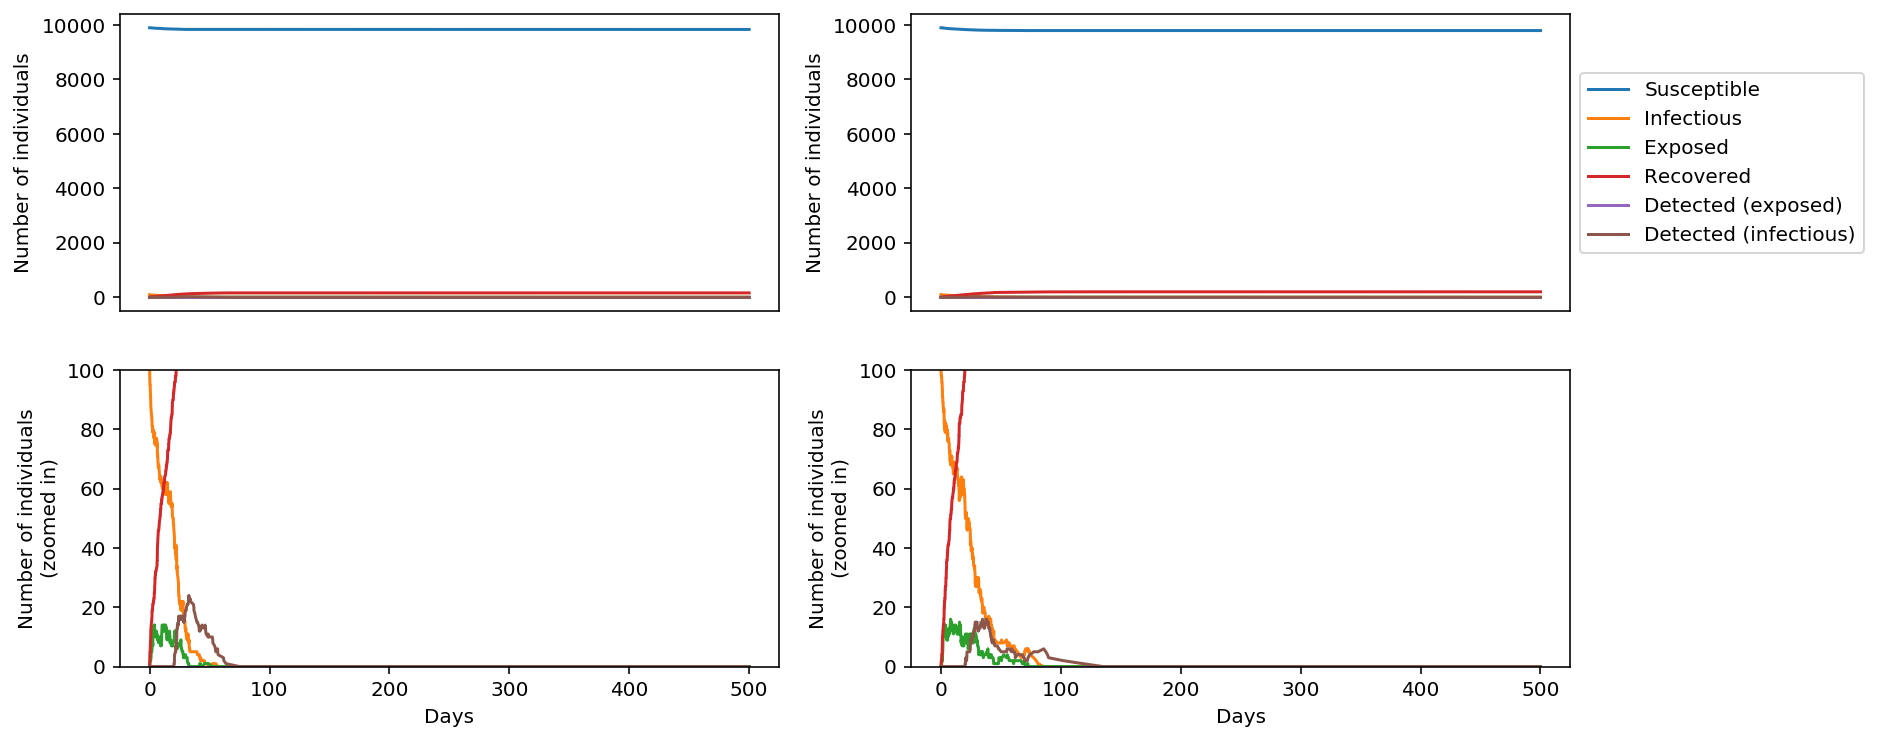

In [40]:
plot_models(models[1], models[2])

0.04445759698908166 -0.003931686470632258


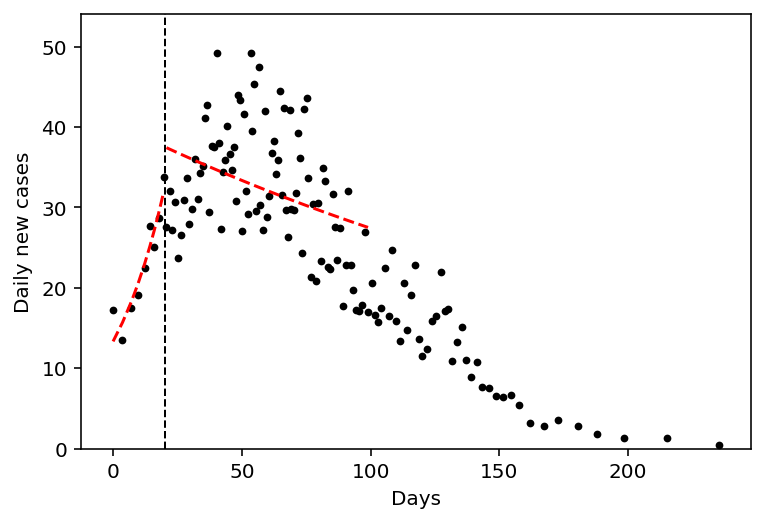

In [32]:
m = models[1]
x = m.tseries[:-100:100]
y = (m.cumE[100::100] - m.cumE[:-100:100]) / (m.tseries[100::100] - m.tseries[:-100:100])
a1, b1 = curve_fit(lambda t,a,b: a * np.exp(b * t), x[x < 20],  y[x < 20])[0]
plt.plot(x[x < 20], (a1 * np.exp(b1 * x))[x < 20], linestyle="dashed", color="red")

segment = (x >= 20) & (x < 100)
a2, b2 = curve_fit(lambda t,a,b: a * np.exp(b * t), x[segment],  y[segment], p0=(100, 0))[0]
plt.plot(x[segment], (a2 * np.exp(b2 * x))[segment], linestyle="dashed", color="red")

#a3, b3 = curve_fit(lambda t,a,b: a * np.exp(b * t), x[x >= 100],  y[x >= 100], p0=(100, 0))[0]
#plt.plot(x[x >= 100], (a3 * np.exp(b3 * x))[x >= 100], linestyle="dashed", color="red")


plt.scatter(x, y, marker='.', lw=0, s=60, color="black")
plt.vlines(20, 0, np.max(y)*1.1, linestyle="dashed", color="black", lw=1)
plt.ylim(0, np.max(y)*1.1)
plt.ylabel("Daily new cases")
plt.xlabel("Days")
print(b1, b2)